This Jupyter notebook, which is based on Python 3, is designed to calculate the abundances of N elements in the neutron star merger mixture. The notebook will contain several functions to easily calculate values such as temperature, abundances, and ionization potentials.

In this notebook, I have a function for the potentials, initialization of values, calculation of abundances, and plotting

In [1]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc

import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from '/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py'>

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.abs(ion_energies1d[counter]))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
    ion_energies[-1][-2]
        
    for i in range(len(elements)):
        returned_potentials.append(ion_energies[elements[i]])        
        
    return returned_potentials

In [4]:
#This cell is simply for temperature, and since it does not change no matter the elements used, I do not use a function
#At some point, I will have to find a way to find the places to calculate the indices to use to find slope for other hdf5s
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []

linear = np.polyfit(np.log10(np.array(time[900:1700])),np.log10(np.array(temperature[900:1700])),1)
m = linear[0]

for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])

In [5]:
#initialization of ionization potentials and full abundances from Skynet
#used in the abundance calculation function
abundance = hf["Y"]
charge = hf["Z"]
density = hf["Density"]
kbEvpGK = 8.617e-5*1e9

def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

In [6]:
#Abundance function
def abundance_calculation(elements):
    x,y = initialization(elements)
    return np.array(saha_mult.GetAbundances(x,np.array(full_temp),np.array(density),y))

In [7]:
#Call to function to generate data
YI = abundance_calculation([62])

/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:109: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:110: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:121: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Abundance')

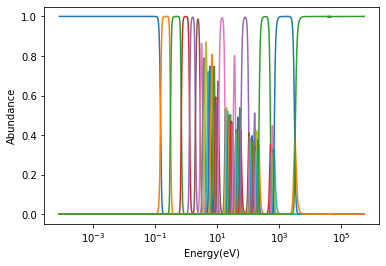

In [8]:
def plotter(abun):
    Ytot = np.sum(YI[0],1)
    for i in range(len(YI[0][0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot)

    plt.xlabel("Energy(eV)")
    plt.ylabel("Abundance")